<a href="https://colab.research.google.com/github/Nungdoo/deep-learning-study/blob/main/exercise08_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망 구현하기

**합성곱 신경망의 정방향 계산 구현하기**

forpass()
- conv2d 함수를 통해 합성곱 수행
- 가중치 self.conv_w : 3 X 3 X 1 X 10
- 커널마다 1개의 절편, 총 10개의 절편을 더함 self.conv_b
- 1차원 배열 self.conv_b는 conv2d() 함수의 결과 마지막 차원에 브로드캐스팅 됨
- 풀링으로 줄어든 특성 맵을 배치 차원을 제외한 나머지 차원만 펼침

In [ ]:
import tensorflow as tf

def forpass(self, x):
  # 3 X 3 합성곱 연산을 수행합니다.
  c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
  # 렐루 함수를 적용합니다.
  r_out = tf.nn.relu(c_out)
  # 2 X 2 최대 풀링을 적용합니다.
  p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
  # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
  f_out = tf.reshape(p_out, [x.shape[0], -1])

  # 완전연결층
  z1 = tf.matmul(f_out, self.w1) + self.b1          # 첫 번째 층의 선형식 계산
  a1 = tf.nn.relu(z1)                               # 활성화 함수 적용
  z2 = tf.matmul(a1, self.w2) + self.b2             # 두 번째 층의 선형식 계산
  return z2

**합성곱 신경망의 역방향 계산 구현하기**

그레이디언트를 구하기 위해 텐서플로의 자동 미분 기능을 사용
- 임의의 파이썬 코드나 함수에 대한 미분값 계산 가능
- with 블럭으로 tf.GradientTape() 객체가 감시할 코드를 감쌈
- tape 객체는 with 블럭 안에서 일어나는 모든 연산을 기록하고 텐서플로 변수인 tf.Variable 객체를 자동으로 추적함

In [2]:
import tensorflow as tf
import numpy as np

x = tf.Variable(np.array([1.0, 2.0, 3.0]))
with tf.GradientTape() as tape:
  y = x ** 3 + 2 * x + 5

# 그레이디언트를 계산합니다.
print(tape.gradient(y, x))

tf.Tensor([ 5. 14. 29.], shape=(3,), dtype=float64)


자동 미분 기능을 이용하면, backprop() 함수 구현할 필요 없음

training()
- backprop() 호출하던 부분 제거
- softmax_cross_entropy_with_logits() 함수를 이용해 정방향 계산의 결과(z)와 타깃(y)을 기반으로 손실값 계산
- softmax_cross_entropy_with_logits() 함수는 배치의 각 샘플에 대한 손실을 반환하므로 reduce_mean()을 이용해 평균 계산

그레이디언트 계산하기
- tape.gradient() 함수를 이용해 자동으로 계산
- optimizer.apply_gradients() 함수를 이용해 가중치 업데이트


In [ ]:
def training(self, x, y):
  m = len(x)
  with tf.GradientTape() as tape:
    # 정방향 계산 수행
    z = self.forpass(x)
    # 손실 계산
    loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
    loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
    # 가중치에 대한 그레이디언트를 계산합니다.
    grads = tape.gradient(loss, weights_list)
    # 가중치를 업데이트합니다.
    self.optimizer.apply_gradients(zip(grads, weights_list))

**옵티마이저 객체를 만들어 가중치 초기화하기**

fit()
- 확률적 경사 하강법을 사용하는 옵티마이저 생성

In [ ]:
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1])                     # 은닉층과 출력층의 가중치 초기화
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)

    for i in range(epochs):
      loss = 0
      print('에포크', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):               # 미니 배치 순환
        print('.', end='')
        self.training(x_batch, y_batch)
        # 배치 손실을 기록합니다.
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print( )
      # 배치 손실 평균을 내어 훈련 손실값으로 저장합니다.
      self.losses.append(np.mean(batch_losses))
      # 검증 세트에 대한 손실을 계산합니다.
      self.val_losses.append(self.get_loss(x_val, y_val))

init_weights()
- glorot_uniform() 함수를 이용해 가중치 초기화
- 자동 미분 기능을 사용하기 위해 가중치를 tf.Variable() 함수로 만들어야 함

글로럿 초기화 방식
- 신경망 모델이 커지만 손실 함수도 복잡해져 출발점에 따라 결과가 달라질 수 있음
- 가중치를 잘못 초기화하면 전역 최적점이 아닌, 지역 최적점을 찾음
- glorot_uniform() 함수로 만든 객체에 필요한 가중치 크기를 전달

In [ ]:
def init_weights(self, input_shape, n_classes):
  g = tf.initializers.glorot_uniform()
  self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
  self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
  n_features = 14 * 14 * self.n_kernels
  self.w1 = tf.Variable(g((n_features, self.units)))
  self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
  self.w2 = tf.Variable(g((self.units, n_classes)))         # (은닉층의 크기, 클래스의 크기)
  self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)   # 클래스의 크기

In [10]:
class ConvolutionNetwork:

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels  # 합성곱의 커널 개수
    self.kernel_size = 3        # 커널 크기
    self.optimizer = None       # 옵티마이저
    self.conv_w = None          # 합성곱층의 가중치
    self.conv_b = None          # 합성곱층의 절편

    self.units = units      # 은닉층의 뉴런 개수
    self.w1 = None          # 은닉층의 가중치
    self.b1 = None          # 은닉층의 절편
    self.w2 = None          # 출력층의 가중치
    self.b2 = None          # 출력층의 절편
    self.a1 = None          # 은닉층의 활성화 출력, 역방향 계산 시 필요하여 저장
    self.losses = []        # 훈련 손실
    self.val_losses = []    # 검증 손실
    self.lr = learning_rate # 학습률
    self.batch_size = batch_size

  def forpass(self, x):
    # 3 X 3 합성곱 연산을 수행합니다.
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
    # 렐루 함수를 적용합니다.
    r_out = tf.nn.relu(c_out)
    # 2 X 2 최대 풀링을 적용합니다.
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
    # 첫 번째 배치 차원을 제외하고 출력을 일렬로 펼칩니다.
    f_out = tf.reshape(p_out, [x.shape[0], -1])

    # 완전연결층
    z1 = tf.matmul(f_out, self.w1) + self.b1          # 첫 번째 층의 선형식 계산
    a1 = tf.nn.relu(z1)                               # 활성화 함수 적용
    z2 = tf.matmul(a1, self.w2) + self.b2             # 두 번째 층의 선형식 계산
    return z2

  def init_weights(self, input_shape, n_classes):
    g = tf.initializers.glorot_uniform()
    self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
    self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
    n_features = 14 * 14 * self.n_kernels
    self.w1 = tf.Variable(g((n_features, self.units)))
    self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
    self.w2 = tf.Variable(g((self.units, n_classes)))         # (은닉층의 크기, 클래스의 크기)
    self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)   # 클래스의 크기

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1])                     # 은닉층과 출력층의 가중치 초기화
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)

    for i in range(epochs):
      loss = 0
      print('에포크', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):               # 미니 배치 순환
        print('.', end='')
        self.training(x_batch, y_batch)
        # 배치 손실을 기록합니다.
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print( )
      # 배치 손실 평균을 내어 훈련 손실값으로 저장합니다.
      self.losses.append(np.mean(batch_losses))
      # 검증 세트에 대한 손실을 계산합니다.
      self.val_losses.append(self.get_loss(x_val, y_val))

  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  def training(self, x, y):
    m = len(x)
    with tf.GradientTape() as tape:
      # 정방향 계산 수행
      z = self.forpass(x)
      # 손실 계산
      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]
    # 가중치에 대한 그레이디언트를 계산합니다.
    grads = tape.gradient(loss, weights_list)
    # 가중치를 업데이트합니다.
    self.optimizer.apply_gradients(zip(grads, weights_list))  

  def predict(self, x):
    z = self.forpass(x)
    # 가장 큰 값의 인덱스를 반환합니다.
    return np.argmax(z.numpy(), axis=1) # 정방향 계산으로 얻은 출력값인 Tensor 객체를 넘파이 배열로 바꿈

  def score(self, x, y):
    # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def get_loss(self, x, y):
    # 정방향 계산을 수행합니다.
    z = self.forpass(x)
    # 손실을 계산하여 저장합니다.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

# 합성곱 신경망 훈련하기

In [6]:
# 데이터 세트 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# 훈련 세트와 검증 세트로 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 타깃을 원-핫 인코딩으로 변환
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

# 입력 데이터 준비하기 (일렬로 펼칠 필요 없음, 컬러 채널만 추가)
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
print(x_train.shape)

# 입력 데이터 표준화 전처리
x_train = x_train / 255
x_val = x_val / 255

(48000, 28, 28, 1)


모델 훈련하기
- 합성곱 커널 10개
- 완전 연결층의 뉴런 100개
- 배치 크기 128개
- 학습률 0.01

In [12]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

훈련, 검증 손실 그래프 & 검증 세트 정확도 확인

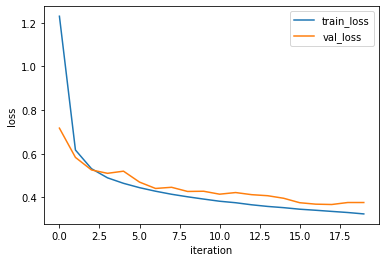

In [13]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [14]:
cn.score(x_val, y_val_encoded)

0.867